<a href="https://colab.research.google.com/github/jimsjoo/gilbut_portfolio/blob/master/5%EC%9E%A5_%EB%B8%94%EB%9E%99_%EB%A6%AC%ED%84%B0%EB%A7%8C%EB%AA%A8%EB%8D%B8(BL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#%matplotlib inline
import matplotlib.pylab as plt
#plt.rcParams["figure.figsize"] = (10, 9)

In [0]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from pandas_datareader import data as web

In [0]:
from scipy.optimize import minimize

In [0]:
# 무위험수익률, 수익률,공분산으로
# 샤프비율을 최대로 하는 접점포트폴리오 비중 계산 
def solveWeights(R, C, rf):
    
    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, rf):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        #샤프비율을 효용함수로 한다
        util = (mean - rf) / np.sqrt(var) 
        # 효용함수 극대화= 효용함수 역함수를 최소화하는 것이다.
        return 1 / util  

    n = len(R)  # 투자자산 갯수

    # 동일비중으로 최적화 시작
    W = np.ones([n]) / n  
    # 비중범위는 0~100%사이(공매도나 차입조건이 없음)
    bnds = [(0., 1.) for i in range(n)]  
    # 제약조건은 비중합=100%
    cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) 
    # 최적화
    res = minimize(obj, W, (R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)
    if not res.success:
      # 최적화 실패한 경우 
      raise BaseException(res.message)
    # 최적화 결과를 돌려준다  
    return res.x

In [0]:
# 무위험수익률, 수익률,공분산으로 효율적 프런티어 계산
def solveFrontier(R, C, rf):

    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, r):
        # 주어진 수익률에서 분산을 최소로 하는 비중 계산
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r)             
        return var + penalty

    # 효율적 프론티어를 구성하는 평균-분산을 돌려줄
    # 리스트를 미리 준비한다
    frontier_mean, frontier_var = [], []

    n = len(R)  # 투자자산 갯수

    # 수익률 최저~최대 사이를 반복한다
    for r in np.linspace(min(R), max(R), num=20):
        # 최적화 함수에 전달할 초기값으로 동일비중으로 시작한다
        W = np.ones([n]) / n 

        # 최적화 함수에 전달할 범위조건과 제약조건을 미리 준비한다
        # 범위조건: 각 구성자산의 투자비중은 0~100% 사이이며
        # 제약조건: 전체 투자비중은 100%이다.
        bnds = [(0, 1) for i in range(n)]
        cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        
        # 최적화 함수 minimize()은 최적화할 obj함수와 
        # 최적화를 시작할 초깃값을 인수로 받는다.         
        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)
        if not res.success:
            # 최적화에 실패한 경우
            raise BaseException(res.message)
        
        # 효율적 프런티어 평균과 분산리스트에 
        # 최적포트폴리오 수익률과 분산 추가
        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))
    return np.array(frontier_mean), np.array(frontier_var)

In [0]:
# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf):

    # 접점포트폴리오 계산
    W = solveWeights(R, C, rf)
    # 투자비중으로 계산한 평균과 분산
    tan_mean = sum(R * W)
    tan_var = np.dot(np.dot(W, C), W)    

    # 효율적 포트폴리오 계산
    eff_mean, eff_var = solveFrontier(R, C, rf)

    # 비중, 접점포트폴리오의 평균/분산, 효율적 포트폴리오의 평균/분산을
    # 딕셔너리 데이터형으로 돌려준다    
    return {'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var}

In [0]:
# 자산에 대한 투자자의 전망과 전망의 기대수익률을 행렬로 만든다
def CreateMatrixPQ(names, views):
    r, c = len(views), len(names)

    # 투자전망과 기대수익률 행렬
    # views[i][3]에는 기대수익률을 가리킴
    Q = [views[i][3] for i in range(r)]     

    # 전망행렬 P를 만들기 위해
    # 구성자산 딕셔너리 작성
    nameToIndex = dict()    
    for i, n in enumerate(names):
        nameToIndex[n] = i

    # 투자전망 
    P = np.zeros([r, c]) 
    for i, v in enumerate(views):
        # 가령 전망이 ('MSFT', '>', 'GE', 0.02) 이라면
        # views[i][0] <-- 'MSFT' --> name1
        # views[i][1] <-- '>'
        # views[i][2] <-- 'GE'   --> name2
        # views[i][3] <-- '0.02'
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return np.array(Q), P

데이터 읽기

In [0]:
tickers= ['XOM', 'AAPL', 'MSFT', 'JNJ', 'GE', 'GOOG', 'CVX', 'PG', 'WFC']
cap = {'XOM': 403.02e9, 'AAPL': 392.90e9, 'MSFT': 283.60e9, 
       'JNJ': 243.17e9, 'GE': 236.79e9,   'GOOG': 292.72e9, 
       'CVX': 231.03e9, 'PG': 214.99e9,   'WFC': 218.79e9 }

prices, caps = [], []
for s in tickers:
    dataframe = pd.read_csv('https://raw.githubusercontent.com/jimsjoo/gilbut_portfolio/master/Data/%s.csv' % s, index_col=None, parse_dates=['date'])
    prices.append(list(dataframe['close'])[-500:])
    caps.append(cap[s])

최적화에 사용할 필요한 값을 미리 계산

In [0]:
n = len(tickers)
W = np.array(caps) / sum(caps) # 시가총액의 비율계산

prices = np.matrix(prices)  # prices를 numpy matrix로 변환

# 수익률 행렬을 만들어 계산
rows, cols = prices.shape
returns = np.empty([rows, cols - 1])
for r in range(rows):
    for c in range(cols - 1):
        p0, p1 = prices[r, c], prices[r, c + 1]
        returns[r, c] = (p1 / p0) - 1

# 수익률계산
expreturns = np.array([])
for r in range(rows):
    expreturns = np.append(expreturns, np.mean(returns[r]))

# 공분산계산
covars = np.cov(returns)
R = (1 + expreturns) ** 250 - 1  # 연율화
C = covars * 250  # 연율화

# 무위험 이자율
rf = .015 

In [183]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=tickers).T)

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Return,7.30%,12.95%,17.20%,14.38%,14.04%,33.20%,9.21%,11.22%,26.89%
Weight (based on market cap),16.01%,15.61%,11.27%,9.66%,9.41%,11.63%,9.18%,8.54%,8.69%


In [184]:
display(pd.DataFrame(C, columns=tickers, index=tickers))

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
XOM,3.90%,2.23%,2.80%,1.96%,3.66%,2.67%,3.82%,1.82%,4.30%
AAPL,2.23%,9.18%,2.46%,1.16%,2.78%,3.32%,2.82%,1.15%,3.68%
MSFT,2.80%,2.46%,5.10%,1.68%,3.26%,2.62%,3.08%,1.37%,4.03%
JNJ,1.96%,1.16%,1.68%,1.95%,2.10%,1.55%,2.10%,1.32%,2.69%
GE,3.66%,2.78%,3.26%,2.10%,5.92%,3.11%,4.07%,1.94%,5.39%
GOOG,2.67%,3.32%,2.62%,1.55%,3.11%,6.69%,3.03%,1.51%,3.90%
CVX,3.82%,2.82%,3.08%,2.10%,4.07%,3.03%,5.09%,1.96%,4.83%
PG,1.82%,1.15%,1.37%,1.32%,1.94%,1.51%,1.96%,2.52%,2.25%
WFC,4.30%,3.68%,4.03%,2.69%,5.39%,3.90%,4.83%,2.25%,8.98%


과거 데이터를 이용한 최적화

In [0]:
opt1 = optimize_frontier(R, C, rf)  

블랙-리터만 역최적화

In [0]:
# 포트폴리오 수익률 평균 및 분산
mean = sum(R * W)
var = np.dot(np.dot(W, C), W)

# 위험회피계수
lmb = (mean - rf) / var  

# 균형초과수익률
Pi = np.dot(np.dot(lmb, C), W) 

균형기대수익률로 최적화

In [0]:
opt2 = optimize_frontier(Pi+rf, C, rf)

투자자 전망과 기대수익률 그리고 전망의 불확실성 계산

In [0]:
views = [('MSFT', '>', 'GE', 0.02),
         ('AAPL', '<', 'JNJ', 0.02)]

Q, P = CreateMatrixPQ(tickers, views)

# 위험조정상수
tau = .025  

# 투자자 전망의 불확실성 계산
# tau * P * C * transpose(P)
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  

블랙-리터만 모델 최적화

In [0]:
# 투자자 전망과 합쳐진 균형초과수익률 계산
sub_a = inv(np.dot(tau, C))
sub_b = np.dot(np.dot(np.transpose(P), inv(omega)), P)
sub_c = np.dot(inv(np.dot(tau, C)), Pi)
sub_d = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
Pi_adj = np.dot(inv(sub_a + sub_b), (sub_c + sub_d))

opt3 = optimize_frontier(Pi_adj + rf, C, rf)

In [190]:
from IPython.core.display import display, HTML
pd.options.display.float_format = '{:.2%}'.format

display(HTML('<h2>Historical returns</h2>'))
display(pd.DataFrame({'Weight': opt1['weights']}, index=tickers).T)

display(HTML('<h2>Implied returns</h2>'))
display(pd.DataFrame({'Weight': opt2['weights']}, index=tickers).T)

display(HTML('<h2>Implied returns with adjusted views</h2>'))
display(pd.DataFrame({'Weight': opt3['weights']}, index=tickers).T)

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.00%,0.00%,0.00%,45.09%,0.00%,52.84%,0.00%,0.00%,2.07%


,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,16.04%,15.62%,11.25%,9.74%,9.38%,11.62%,9.18%,8.47%,8.70%


,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,15.26%,3.28%,22.62%,21.89%,0.00%,11.59%,8.78%,8.43%,8.15%


In [0]:
def plotAssets(tickers, R, C, color='black'):
    # 포트폴리오 구성자산 출력
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color)  
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color) 

def plotFrontier(result, label=None, color='black'):
    # 최적화된 효율적 프런티어 출력
    plt.text(result['tan_var'] ** .5, result['tan_mean'], 'tangent', verticalalignment='center', color=color)
    plt.scatter(result['tan_var'] ** .5, result['tan_mean'], marker='o', color=color)
    plt.plot(result['eff_var'] ** .5, result['eff_mean'], label=label, color=color, linewidth=2, marker='D', markersize=9) 

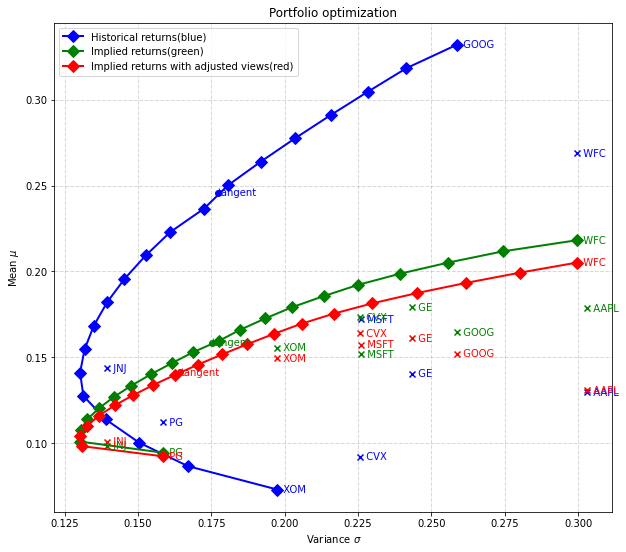

In [192]:
plotAssets(tickers, R, C, color='blue')
plotFrontier(opt1, label='Historical returns', color='blue')

plotAssets(tickers, Pi+rf, C, color='green')
plotFrontier(opt2, label='Implied returns', color='green')

plotAssets(tickers, Pi_adj+rf, C, color='red')
plotFrontier(opt3, label='Implied returns (adjusted views)', color='red')

plt.grid(alpha=0.3, color='gray', linestyle='--', linewidth=1)
plt.title('Portfolio optimization')
plt.legend(['Historical returns(blue)', 'Implied returns(green)','Implied returns with adjusted views(red)'])
plt.xlabel('Variance $\sigma$')
plt.ylabel('Mean $\mu$')
plt.show()